In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import cond_color
from cond_color import get_colors,plot_end,plot_start

In [30]:
# load data
data = np.load('psths.npz')
X,times = data['X'],data['times']
# X[i, c, t] is the average firing rate of neuron i in the t-th time bin in condition c (in units of Hz or spikes per second).
print(X.shape)
# times, with the start time (in milliseconds) of the different PSTH bins relative to movement onset 
print(times.shape)

(182, 108, 130)
(130,)


Question 1

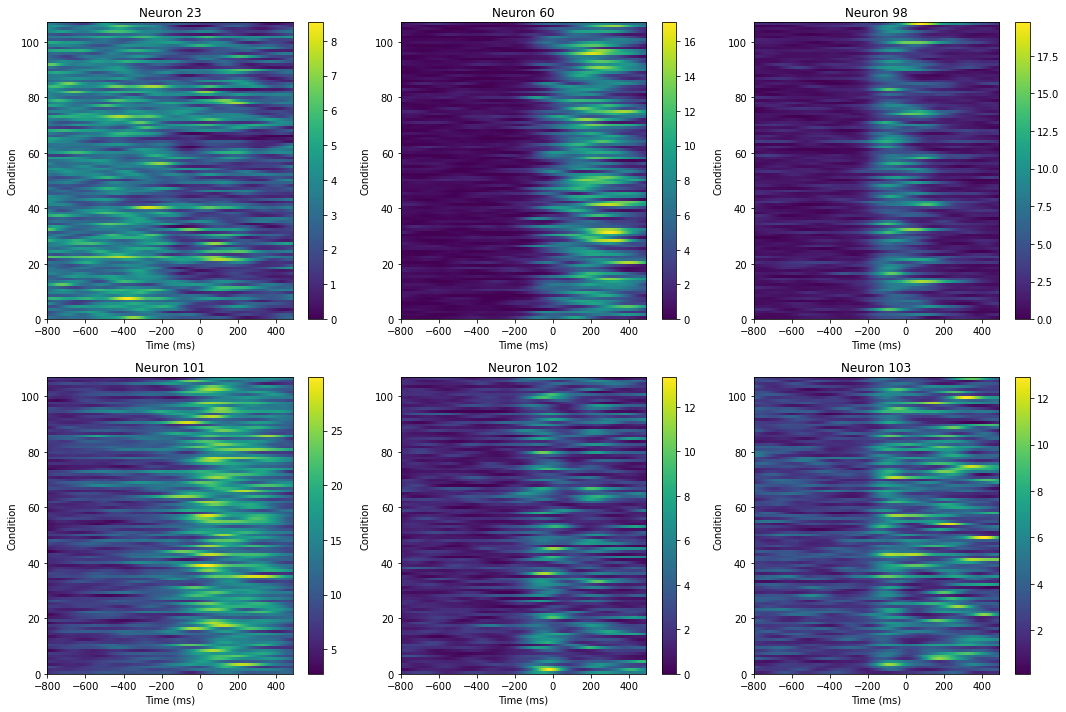

In [29]:
# select 6 random neurons
neurons = [23,60,98,101,102,103]
n_neurons = 9
#neurons = np.random.choice(X.shape[1],n_neurons,replace=False)
conditions = np.arange(X.shape[1]) 

# create a 2,3 figure
fig, axs = plt.subplots(2,3,figsize=(15,10))
# plot C against time for each neuron
for i,neuron in enumerate(neurons):
    # get the data for the neuron
    C = X[neuron,:,:]
    # Plot the data as a 2D histogram
    im = axs[i // 3, i % 3].imshow(C, aspect='auto', interpolation='nearest', extent=[times[0], times[-1], conditions[0], conditions[-1]])
    fig.colorbar(im, ax=axs[i // 3, i % 3])

    # Add title, x label, and y label
    axs[i // 3, i % 3].set_title('Neuron {}'.format(neuron))
    axs[i // 3, i % 3].set_xlabel('Time (ms)')
    axs[i // 3, i % 3].set_ylabel('Condition')

plt.tight_layout()
plt.show()

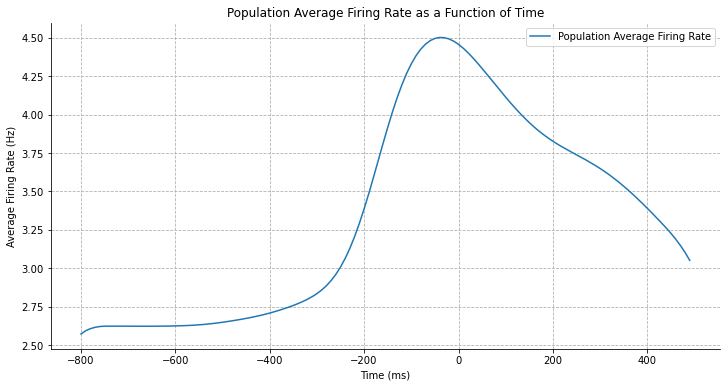

In [4]:
population_avg_firing_rate = X.mean(axis=(0, 1))

# Plotting the population average firing rate as a function of time
plt.figure(figsize=(12, 6))
sns.lineplot(x=times, y=population_avg_firing_rate, label='Population Average Firing Rate')

plt.xlabel('Time (ms)')
plt.ylabel('Average Firing Rate (Hz)')
plt.title('Population Average Firing Rate as a Function of Time')
plt.legend()
sns.despine()  # Removing the top and right spines for a cleaner look
plt.grid(True, linestyle='--')
plt.show()

Question 2

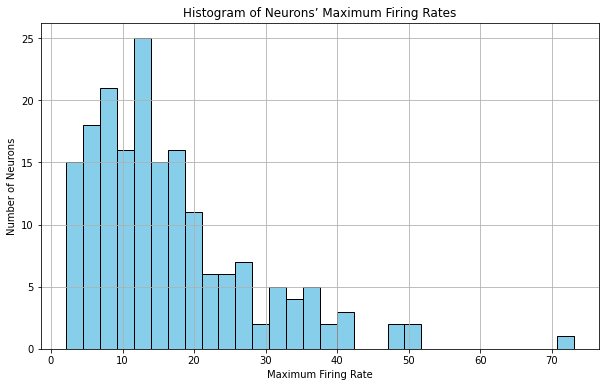

In [5]:
# Calculating the maximum firing rate for each neuron across conditions and time
max_firing_rates = X.max(axis=(1, 2))

# Plotting the histogram of the neurons' maximum firing rates
plt.figure(figsize=(10, 6))
plt.hist(max_firing_rates, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Maximum Firing Rate')
plt.ylabel('Number of Neurons')
plt.title('Histogram of Neurons’ Maximum Firing Rates')
plt.grid(True)
plt.show()


In [6]:
# Normalizing each neuron's PSTH
X_normalized = np.zeros_like(X)
for neuron in range(X.shape[0]):
    psth = X[neuron, :, :]
    a = psth.max()
    b = psth.min()
    X_normalized[neuron, :, :] = (psth - b) / (a - b + 5)

# Removing the cross-condition mean from X_normalized
# Calculating and subtracting separately for each time bin and neuron

for neuron in range(X_normalized.shape[0]):
    for time in range(X_normalized.shape[2]):
        # Calculate the mean across conditions for each neuron and time bin
        mean_across_conditions = X_normalized[neuron, :, time].mean()
        # Subtract the mean from each condition's value
        X_normalized[neuron, :, time] = X_normalized[neuron, :, time] - mean_across_conditions



In [7]:
# First, we need to find the indices corresponding to the -150ms to +300ms interval
time_interval_start_idx = np.where(times >= -150)[0][0]
time_interval_end_idx = np.where(times <= 300)[0][-1]

# Extracting the slice of the normalized and mean-removed PSTH array corresponding to this time interval
X_interval = X_normalized[:, :, time_interval_start_idx:time_interval_end_idx + 1]

# Reshaping X into a N × CT matrix by combining its condition and time axes
N, C, T = X_interval.shape
X_reshaped = X_interval.reshape(N, C * T)

# Applying PCA to obtain a dimensionality-reduced version of it
M = 12  # Number of principal components
pca = PCA(n_components=M)
Z = pca.fit_transform(X_reshaped.T).T

# The orthonormal matrix V of the eigenvectors
V = pca.components_

print(V.shape,Z.shape)  # Confirming the shape of the resulting arrays V and Z

(12, 182) (12, 4968)


Question 3

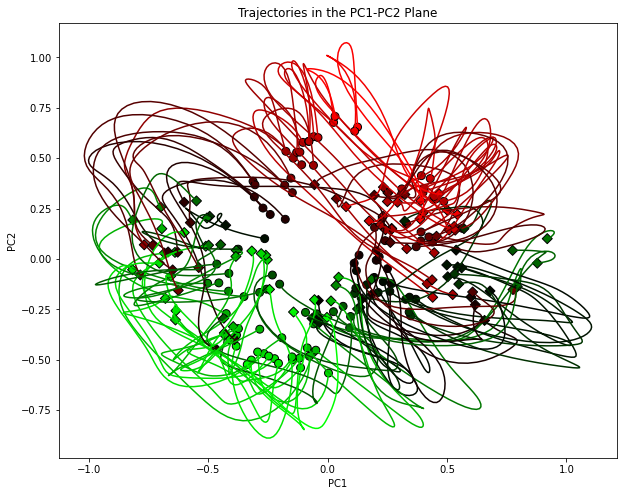

In [8]:
# Reshaping Z back into a 3D array
Z_reshaped = Z.reshape(M, C, T)

# Preparing data for plotting
PC1 = Z_reshaped[0, :, :]  # PC1 for all conditions
PC2 = Z_reshaped[1, :, :]  # PC2 for all conditions

# Initial and final coordinates for each condition
x_init = PC1[:, 0]  # X-coordinates of the initial points
y_init = PC2[:, 0]  # Y-coordinates of the initial points
x_end = PC1[:, -1]  # X-coordinates of the final points
y_end = PC2[:, -1]  # Y-coordinates of the final points

# Getting colors for plotting
colors = get_colors(x_init, y_init)

# Plotting the trajectories
plt.figure(figsize=(10, 8))
for i in range(C):
    plt.plot(PC1[i, :], PC2[i, :], color=colors[i])
m_size = 50
plot_start(x_init, y_init, colors,markersize=5*m_size)
plot_end(x_end, y_end, colors,markersize=m_size)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectories in the PC1-PC2 Plane')
plt.show()

Question 4

In [9]:
# Calculating K for general M and specifically for M = 12
M_general = 12
K_general = M_general * (M_general - 1) // 2
print("K for general M =", K_general)

# Filling H with values in {−1, 0, +1}
def create_H(M):
    K = M * (M - 1) // 2
    H = np.zeros((K, M, M))
    k = 0
    for i in range(M):
        for j in range(i + 1, M):
            H[k, i, j] = 1
            H[k, j, i] = -1
            k += 1
    return H

H = create_H(4)
print(H[1,:,:])
# Example beta
beta = np.array([1, 2, 3, 4, 5, 6])

# Constructing the antisymmetric matrix A
A = np.tensordot(beta, H, axes=1)

# Display the matrix A
print("Antisymmetric matrix A:\n", A)


K for general M = 66
Antisymmetric matrix A:
 [[ 0.  1.  2.  3.]
 [-1.  0.  4.  5.]
 [-2. -4.  0.  6.]
 [-3. -5. -6.  0.]]


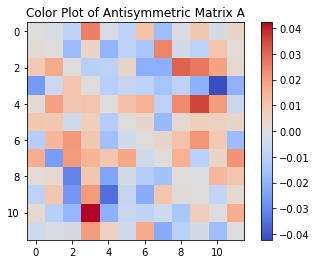

In [10]:
def get_beta(Z_3d):
    # Reshape Z back into a 3D array with shape M x C x T
    M, C, T = Z_3d.shape

    # Compute DeltaZ by taking differences along the time axis
    # DeltaZ will have a shape of M x C x (T - 1)
    DeltaZ = np.diff(Z_3d, axis=2)
    DeltaZ = DeltaZ.reshape(M, C * (T - 1))

    Z_2d = Z_3d[:, :, 1:].reshape(M, C * (T - 1))

    H = create_H(M)
    # Compute W using the tensor dot product of H and Z
    # W will have a shape of K x M x C(T - 1)
    W = np.tensordot(H, Z_2d, axes=1)

    # Calculate b and Q
    b = np.einsum('im,aim->a', DeltaZ, W)  # Using Einstein summation convention for clarity
    Q = np.einsum('aim,bim->ab', W, W)      # Einstein summation convention

    # Solve for beta
    beta = np.linalg.solve(Q, b)
    

    # Compute A using the 3D array H
    A = np.tensordot(beta, H, axes=1)

    return A

A = get_beta(Z.reshape(M, C, T))

# Plot A
plt.imshow(A, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Color Plot of Antisymmetric Matrix A')
plt.show()

In [11]:
# load data from test.npz
test_data = np.load('test.npz')
Z_test = test_data['Z_test']
A_test = test_data['A_test']

# Calculate A using get_beta()
A = get_beta(Z_test)
# get the difference between A and A_test
diff = A - A_test
# get the maximum difference
max_diff = np.max(np.abs(diff))
print("Maximum difference between A and A_test:", max_diff)


Maximum difference between A and A_test: 8.216290581917161e-05


Question 5

In [12]:
def get_PFR(A,Z,k=1):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Find the eigenvalue with the k-th largest imaginary part
    sorted_indices = np.argsort(-np.abs(np.imag(eigenvalues)))
    max_imag_index = sorted_indices[k-1]
    eigenvalue = eigenvalues[max_imag_index]
    eigenvector = eigenvectors[:, max_imag_index]

    # Normalize the real and imaginary parts of the eigenvector
    real_part = np.real(eigenvector)
    imag_part = np.imag(eigenvector)
    real_part_normalized = real_part / np.linalg.norm(real_part)
    imag_part_normalized = imag_part / np.linalg.norm(imag_part)

    # Construct the projection matrix PFR
    PFR = np.vstack([real_part_normalized, imag_part_normalized])

    return PFR

In [13]:
def plot_fastest_rotation_plane(A, Z, k=1):
    """
    Plots the trajectories in the plane of the k-th fastest rotation induced by A.
    
    :param A: The estimated antisymmetric matrix.
    :param Z: The data matrix.
    :param k: The rank of the eigenvalue to consider (1 for largest, 2 for second-largest, etc.).
    """
    PFR = get_PFR(A, Z, k)

    # Apply PFR to Z to obtain the 2D projection
    Z_FR = np.dot(PFR, Z)

    # Reshaping Z back into a 3D array
    Z_FR_2D = Z_FR.reshape(2, C, T)
    Z_FR_2D = Z_FR_2D[:,:,:-10]
    
    # Preparing data for plotting
    PC1 = Z_FR_2D[0, :, :]  # PC1 for all conditions
    PC2 = Z_FR_2D[1, :, :]  # PC2 for all conditions

    # Initial and final coordinates for each condition
    x_init = PC1[:, 0]  # X-coordinates of the initial points
    y_init = PC2[:, 0]  # Y-coordinates of the initial points
    x_end = PC1[:, -1]  # X-coordinates of the final points
    y_end = PC2[:, -1]  # Y-coordinates of the final points

    # Getting colors for plotting
    colors = get_colors(x_init, y_init)

    # Plotting the trajectories
    plt.figure(figsize=(10, 8))
    for i in range(C):
        plt.plot(PC1[i, :], PC2[i, :], color=colors[i])
    m_size = 50
    plot_start(x_init, y_init, colors, markersize=5*m_size)
    plot_end(x_end, y_end, colors, markersize=m_size)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Trajectories in the kth Fastest Plane')
    plt.show()

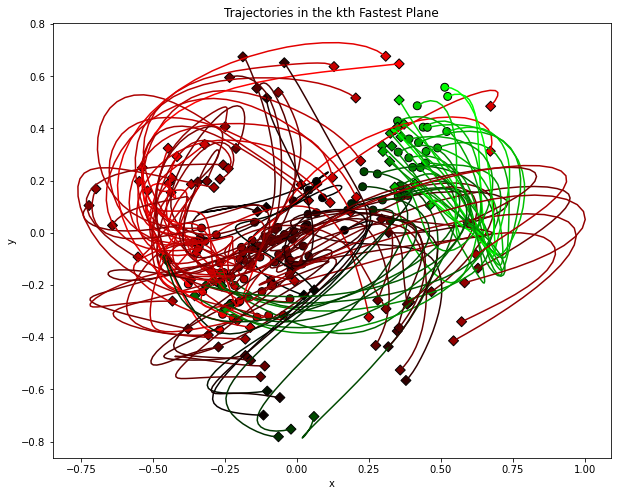

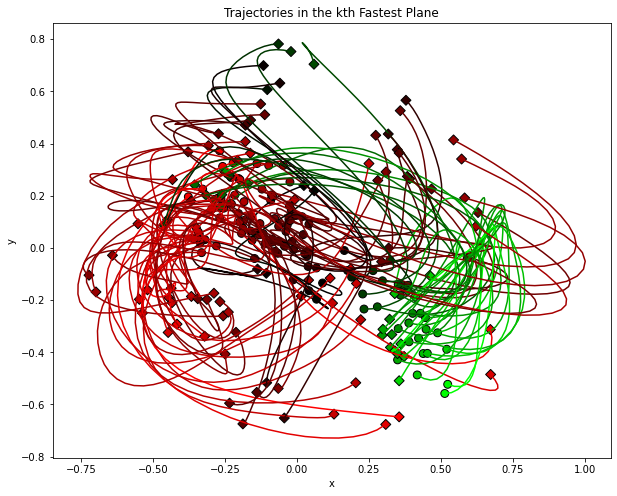

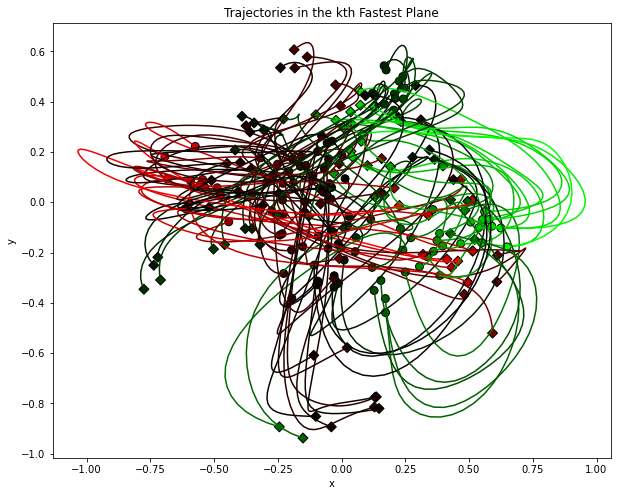

In [14]:
plot_fastest_rotation_plane(A, Z, k=1)
plot_fastest_rotation_plane(A, Z, k=2)
plot_fastest_rotation_plane(A, Z, k=3)


Question 6

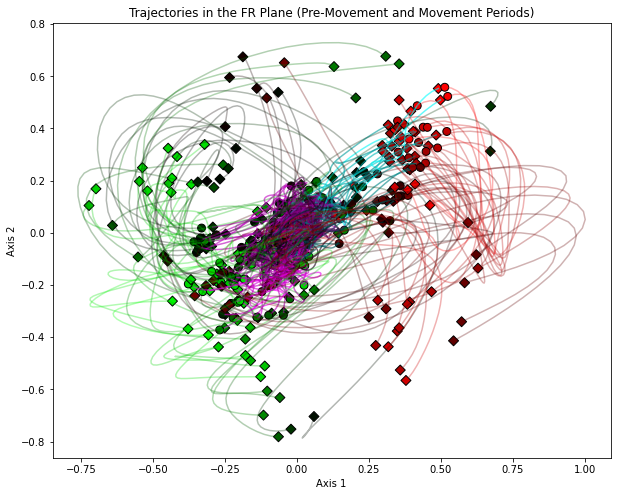

In [15]:
PFR = get_PFR(A,Z,k=1)
PFRVMT = np.dot(PFR, V)

# Apply PFR to Z to obtain the 2D projection
Z_FR = np.dot(PFR, Z)

# Reshaping Z back into a 3D array
Z_FR_2D = Z_FR.reshape(2, C, T)
Z_FR_2D = Z_FR_2D[:,:,:-10]

# Define the indices for the pre-movement period
start_idx = np.where(times >= -800)[0][0]
end_idx = np.where(times <= -150)[0][-1]
X_pre_movement = X_normalized[:, :, start_idx:end_idx]

# Reshape X_pre_movement for projection
N, C, T_pre = X_pre_movement.shape
X_pre_movement_reshaped = X_pre_movement.reshape(N, C * T_pre)

# Project the pre-movement period trajectories onto the FR plane
Z_pre_movement = np.dot(PFRVMT, X_pre_movement_reshaped)

# Reshape back to 2D array for plotting
Z_pre_movement_2D = Z_pre_movement.reshape(2, C, T_pre)

# Extract the final points of the pre-movement period trajectories
x_end_pre = Z_pre_movement_2D[0, :, -1]
y_end_pre = Z_pre_movement_2D[1, :, -1]

# Get colors for plotting (with alt_colors=True)
colors_pre = get_colors(x_end_pre, y_end_pre, alt_colors=True)

# Preparing data for plotting
PC1 = Z_pre_movement_2D[0, :, :]  # PC1 for all conditions
PC2 = Z_pre_movement_2D[1, :, :]  # PC2 for all conditions

# Initial and final coordinates for each condition
x_init = PC1[:, 0]  # X-coordinates of the initial points
y_init = PC2[:, 0]  # Y-coordinates of the initial points
x_end = PC1[:, -1]  # X-coordinates of the final points
y_end = PC2[:, -1]  # Y-coordinates of the final points
# Plotting the trajectories
plt.figure(figsize=(10, 8))
# Plot pre-movement period trajectories
for i in range(C):
    plt.plot(Z_pre_movement_2D[0, i, :], Z_pre_movement_2D[1, i, :], color=colors_pre[i], alpha=0.6)
plot_start(x_init, y_init, colors, markersize=5*m_size)
plot_end(x_end, y_end, colors, markersize=m_size)

# Plot movement period trajectories with reduced alpha
# Assuming Z_FR_2D contains the movement period trajectories
# Preparing data for plotting
PC1 = Z_FR_2D[0, :, :]  # PC1 for all conditions
PC2 = Z_FR_2D[1, :, :]  # PC2 for all conditions

# Initial and final coordinates for each condition
x_init = PC1[:, 0]  # X-coordinates of the initial points
y_init = PC2[:, 0]  # Y-coordinates of the initial points
x_end = PC1[:, -1]  # X-coordinates of the final points
y_end = PC2[:, -1]  # Y-coordinates of the final points

for i in range(C):
    plt.plot(Z_FR_2D[0, i, :], Z_FR_2D[1, i, :], color=colors[i], alpha=0.3)
plot_start(x_init, y_init, colors, markersize=5*m_size)
plot_end(x_end, y_end, colors, markersize=m_size)
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Trajectories in the FR Plane (Pre-Movement and Movement Periods)')
plt.show()

Question 7

In [16]:
t0 = np.where(times == -150)[0][0]
X_distorted = X.copy()
N, C, T = X.shape

for neuron in range(N):
    # Randomly pick half of the conditions for inversion
    conditions_to_invert = np.random.choice(C, C // 2, replace=False)
    for condition in conditions_to_invert:
        X_distorted[neuron, condition, t0:] = 2 * X_distorted[neuron, condition, t0] - X_distorted[neuron, condition, t0:]
    

# Normalizing each neuron's PSTH
X_normalized_distorted = np.zeros_like(X_distorted)
for neuron in range(X_distorted.shape[0]):
    psth = X_distorted[neuron, :, :]
    a = psth.max()
    b = psth.min()
    X_normalized_distorted[neuron, :, :] = (psth - b) / (a - b + 5)

# Removing the cross-condition mean from X_normalized
# Calculating and subtracting separately for each time bin and neuron

for neuron in range(X_normalized_distorted.shape[0]):
    for time in range(X_normalized_distorted.shape[2]):
        # Calculate the mean across conditions for each neuron and time bin
        mean_across_conditions = X_normalized_distorted[neuron, :, time].mean()
        # Subtract the mean from each condition's value
        X_normalized_distorted[neuron, :, time] = X_normalized_distorted[neuron, :, time] - mean_across_conditions

In [17]:
# First, we need to find the indices corresponding to the -150ms to +300ms interval
time_interval_start_idx = np.where(times >= -150)[0][0]
time_interval_end_idx = np.where(times <= 300)[0][-1]

# Extracting the slice of the normalized and mean-removed PSTH array corresponding to this time interval
X_interval = X_normalized_distorted[:, :, time_interval_start_idx:time_interval_end_idx + 1]

# Reshaping X into a N × CT matrix by combining its condition and time axes
N, C, T = X_interval.shape
X_reshaped = X_interval.reshape(N, C * T)

# Applying PCA to obtain a dimensionality-reduced version of it
M = 12  # Number of principal components
pca = PCA(n_components=M)
Z = pca.fit_transform(X_reshaped.T).T

# The orthonormal matrix V of the eigenvectors
V = pca.components_

print(V.shape,Z.shape)  # Confirming the shape of the resulting arrays V and Z

A = get_beta(Z.reshape(M, C, T))

print(A.shape)

(12, 182) (12, 4968)
(12, 12)


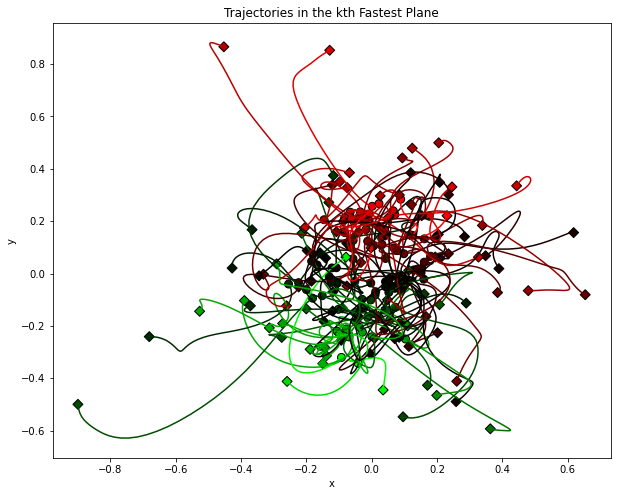

In [18]:
plot_fastest_rotation_plane(A, Z, k=1)